In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from scipy.stats import multivariate_t
import matplotlib.pyplot as plt
from ktvgl_functions2 import init_parameters, fit_multivariate_t, L_update, w_update,  u_update, a_update, V_update, dual_update, residual_Update, update_parameters, updateADMMpenalties, L_star,L_from_w,D_star,D_from_w,A_from_w,compute_augmented_lagrangian

In [2]:
log_rw_returns = pd.read_csv("log_rw_returns.csv")
log_returns = pd.read_csv("log_returns.csv")

In [188]:
def learn_heavytail_tvgl(data_frame,
    winLen = 200,
    w_lagged = 0,
    sigma_e = np.exp(10),
    k = 1, 
    r = 10,
    heavy_type = "student",
    nu = None,
    d = 1,
    gamma = 10,
    eta = 1e-8,
    update_eta = True,
    early_stopping = False,
    rho = 2,
    update_rho = False,
    maxiter = 10,
    reltol = 1e-5,
    verbose = False,
    ):

    '''
    k          Clusters
    sigma_e:   Laplace Scale Parameter
    rho:       ADMM hyperparameter. 
    gamma:     hyperparameter that controls the sparsity of VAR coefficients
    eta:       hyperparameter that controls the regularization to obtain a k-component graph
    '''


    assert isinstance(data_frame, pd.DataFrame), "Must Be Pandas data frame"
    n = data_frame.shape[0] # n_observations
    p = data_frame.shape[1] # n_features
    assert r <= data_frame.shape[1], "r <= data frame columns"
    
    data_frame_raw = log_returns.iloc[:, 0:r] 
 
    rem = n%winLen
    if rem > 0:
        print("Warning: Adjusting Window Length to include all Data")

    nFrames = n//winLen
    nFrame_array = np.linspace(0,n,nFrames+1,dtype=np.int64)
    #print("nFrame_array",nFrame_array)

    nFmax = np.max(np.diff(nFrame_array))
    nFmin = np.min(np.diff(nFrame_array))

    if( np.abs(nFmax/winLen - 1) or np.abs(nFmin/winLen - 1) ) > 0.5:
        print("Warning: Frame length adjusted by more than 50%")

    resTotalFrame = {}
    for frame in range(0,nFrames):

        data_frame = data_frame_raw.iloc[nFrame_array[frame]:nFrame_array[frame+1],:]
        X = scale(data_frame.to_numpy())
        
        # number of observations
        T_n = data_frame.shape[0]      # n_observations in Frame
        p = data_frame.shape[1] # n_features
        sigma_e = np.exp(10)  # 
        alpha = 2/(T_n*sigma_e)
        beta = 2*np.log(sigma_e)/T_n


        # BOOK KEEPING
        # residual vectors
        primal_lap_residual = np.array([], dtype=float)
        primal_deg_residual = np.array([], dtype=float)
        dual_residual       = np.array([], dtype=float)

        lagrangian = np.array([], dtype=float)
        rho_seq = np.array([], dtype=float)
        eta_seq = np.array([], dtype=float)

        elapsed_time = np.array([], dtype=float)


        res = fit_multivariate_t(X)
        nu = res["nu"]

        w, Aw, a, w_lagged, L_n, Phi_n, u_n, mu_vec, d, z_n, V = init_parameters(X,k)

        LstarXsq = [None]*(T_n)
        for t in range(T_n):
            x = X[t, :]
            LstarXsq[t] = L_star(np.outer(x, x))
        
        for iter in range(0,maxiter):

            #print("iter: ",iter+1)
            wUpdate, LwUpdate, AwUpdate   = w_update( X, w, w_lagged, a, nu, LstarXsq, L_n, u_n, mu_vec, z_n, Phi_n, V, rho, d, eta, beta)               
            u_nUpdate = u_update( wUpdate, a, w_lagged, mu_vec, rho, alpha)
            # x_update() # Not Implemented
            aUpdate =a_update( w_lagged, wUpdate, u_nUpdate, mu_vec, gamma, rho)
            vUpdate = V_update(wUpdate,k)
            L_nUpdate = L_update(wUpdate, Phi_n, rho, k)
            Phi_nUpdate, mu_vecUpdate, z_nUpdate, Phi_n_res, u_n_res, z_n_res = dual_update(rho, wUpdate, L_nUpdate, Phi_n, aUpdate, w_lagged, mu_vec, u_nUpdate, d, z_n)
            
            primal_lap_residual, primal_deg_residual, dual_residual = residual_Update(rho, L_n, L_nUpdate, Phi_n_res, z_n_res, primal_lap_residual, primal_deg_residual, dual_residual) 
            #print(np.linalg.norm(L_from_w(wUpdate) - L_from_w(w), 'fro') / np.linalg.norm(L_from_w(w))  < reltol)
            has_converged = (np.linalg.norm(L_from_w(wUpdate) - L_from_w(w), 'fro') / np.linalg.norm(L_from_w(w), 'fro') < reltol) and (iter > 1)
            L_n, w, u_n, a, V, Phi_n, mu_vec, z_n = update_parameters( L_nUpdate, wUpdate, u_nUpdate, aUpdate, vUpdate, Phi_nUpdate, mu_vecUpdate, z_nUpdate)

            lagrangian = compute_augmented_lagrangian(lagrangian, w, LstarXsq, L_n, V, Phi_n, z_n, d, heavy_type, T_n, p, k, rho, eta, nu, w_lagged, u_n, mu_vec, alpha, beta, a, gamma)
            rho, eta, rho_seq, eta_seq, has_converged = updateADMMpenalties( update_rho, rho, rho_seq,L_n, k, wUpdate, update_eta, eta, eta_seq, early_stopping, has_converged)

            
            if has_converged:
                print("Break: Frame Converged")
                break
        print("Fit Complete: Frame " + str(frame)," || Total Iterations: " + str(iter+1))
        if verbose:            
            print("lagrangian:",lagrangian,"primal_lap_residual:",primal_lap_residual,"primal_deg_residual:",primal_deg_residual,"dual_residual:",dual_residual)
        
        resFrame = {"laplacian":L_from_w(w), "adjancey":A_from_w(w), "weights":w, "theta":L_n, "maxiter":iter,"nu_init":nu,
                    "convergence":has_converged, "eta_seq":eta_seq,
                    "primal_lap_residual":primal_lap_residual,
                    "primal_deg_residual":primal_deg_residual,
                    "dual_residual":dual_residual,
                    "lagrangian":lagrangian,
                    "elapsed_time":elapsed_time}
        
        resTemp = {"Frame"+str(frame): resFrame}
        resTotalFrame.update(resTemp)

        w_lagged = w # Set for next frame


    return resTotalFrame

In [6]:
resTotalFrame = learn_heavytail_tvgl(log_returns,maxiter=1000)
print(resTotalFrame["Frame0"]["nu_init"])
print(resTotalFrame["Frame0"]["lagrangian"])
print(resTotalFrame["Frame0"]["weights"])

Break: Frame Converged
Fit Complete: Frame 0  || Total Iterations: 338
Break: Frame Converged
Fit Complete: Frame 1  || Total Iterations: 275
Break: Frame Converged
Fit Complete: Frame 2  || Total Iterations: 325
Break: Frame Converged
Fit Complete: Frame 3  || Total Iterations: 271
Break: Frame Converged
Fit Complete: Frame 4  || Total Iterations: 315
4.042160984636169
[40.18389467 16.34053466 12.51945138 15.55310542 16.09221802 15.17228841
 14.24760352 14.28954688 14.23298007 14.03901249 13.95244885 13.9287291
 13.93542788 13.94326674 13.93999225 13.92569831 13.90567335 13.69611713
 13.67461772 13.66010592 13.65166012 14.35357583 13.40947805 13.37344739
 13.33475094 13.30984211 13.30219685 13.30775302 13.23008444 13.24467869
 13.25127607 13.24971019 13.65721496 13.06152203 13.06861817 13.066977
 13.06390823 13.06100207 13.05708011 13.05134713 12.95453059 12.95176925
 12.94907453 12.94753268 13.247382   12.93686857 12.94470867 12.95024664
 12.9529681  12.95303458 12.95105031 12.947798

[4.996718026213952, 3.9503586635759493, 5.208274823523776, 4.4203585535944, 4.604402455357204, 3.7949499911475923, 6.974831057609652, 3.956404866770347, 4.776293899573784, 4.45086216246736, 3.6843201454619194, 5.368841729091618, 4.49366779902406, 4.336261193972148, 3.6759939659728116, 3.582622405649112, 4.5752708356715655, 4.35371672941028, 3.932047546354165, 4.014106939247912, 3.788230164578318, 3.9049138592920802, 4.253293813971013, 4.558057309799637, 4.3794784272850436, 3.679513457921203, 4.292410371389328, 3.563677699157403, 4.2697041633830235, 4.096670368326542, 4.406938917508328, 4.106400925274231, 4.354774286655185, 4.585869345621692, 3.6717284282733327, 4.291058399254483, 4.267908206220722, 4.340055083758004, 3.9260985079735473, 4.34251701846149, 4.455798403093117, 3.764962789678301, 4.215795980691315, 4.496234544375017, 4.075675323887544, 4.566109091451281, 4.418784588945827, 4.02084678286966, 4.52531375873692, 4.233747906480639, 4.117358626656817, 4.222874998693048, 3.9172235

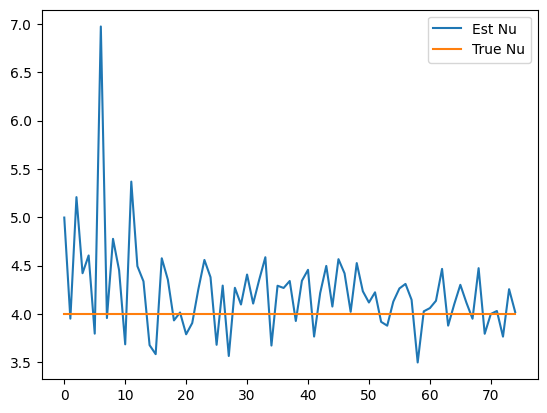

In [41]:
N = 10
num_obs = 200 

mu = np.zeros(N)
data = np.random.rand(N, num_obs)
cov = np.cov(data, ddof=1)
nu = 4
rv = multivariate_t(loc=mu,shape=cov,df=nu)


est_nu = []
num_samples_array = np.arange(20,1520,20).tolist()

for num_samples in num_samples_array:
    random_samples = rv.rvs(size=num_samples)
    random_samples.shape
    res = fit_multivariate_t(random_samples,ptol=1e-8)
    #print(res["num_iterations"])

    est_nu.append(res["nu"])

print(est_nu)

plt.plot(est_nu,label="Est Nu")
plt.plot([nu for _ in range(0,len(est_nu))],label="True Nu")
plt.legend();

diff Time Series Shape:  (5000, 10)
Time Series Shape:  (5001, 10)


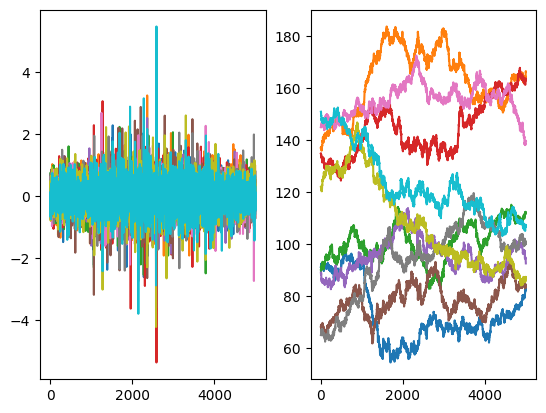

In [130]:
N = 10
num_obs = 50 
num_samples = 1000
cov_array = list()
diffTimeSeries = np.empty((0,N))
nuArray = np.random.randint(2,10,20)
for i in range(0,5):
    mu = np.zeros(N)
    data = np.random.rand(N, num_obs)
    cov = np.cov(data, ddof=1)
    cov_array.append(cov)
    nu = nuArray[i]
    rv = multivariate_t( loc=mu, shape=cov, df=nu)
    random_samples = rv.rvs(size=num_samples)
    diffTimeSeries = np.vstack((diffTimeSeries,random_samples))

print("diff Time Series Shape: ",diffTimeSeries.shape)

TimeSeries = np.cumsum(diffTimeSeries,axis=0)
MinValue = np.ceil(np.abs(np.min(TimeSeries)*1.1))
InitArray = np.random.randint(low=MinValue, high=MinValue+100,size=N)
TimeSeries = np.cumsum( np.vstack((InitArray,diffTimeSeries) ),axis=0 )
print("Time Series Shape: ",TimeSeries.shape)



fig,axe = plt.subplots(1,2)
axe[0].plot(diffTimeSeries);
axe[1].plot(TimeSeries);


In [ ]:
log_returns_np = np.diff(np.log(TimeSeries),axis=0)
log_returns = pd.DataFrame(log_returns_np)

log_returns.shape

(5000, 10)

In [168]:
resTotalFrame = learn_heavytail_tvgl(log_returns,maxiter=1000)

Break: Frame Converged
Fit Complete: Frame 0  || Total Iterations: 302
Break: Frame Converged
Fit Complete: Frame 1  || Total Iterations: 293
Break: Frame Converged
Fit Complete: Frame 2  || Total Iterations: 307
Break: Frame Converged
Fit Complete: Frame 3  || Total Iterations: 297
Break: Frame Converged
Fit Complete: Frame 4  || Total Iterations: 391
Break: Frame Converged
Fit Complete: Frame 5  || Total Iterations: 351
Break: Frame Converged
Fit Complete: Frame 6  || Total Iterations: 256
Break: Frame Converged
Fit Complete: Frame 7  || Total Iterations: 313
Break: Frame Converged
Fit Complete: Frame 8  || Total Iterations: 293
Break: Frame Converged
Fit Complete: Frame 9  || Total Iterations: 372
Break: Frame Converged
Fit Complete: Frame 10  || Total Iterations: 319
Break: Frame Converged
Fit Complete: Frame 11  || Total Iterations: 297
Break: Frame Converged
Fit Complete: Frame 12  || Total Iterations: 260
Break: Frame Converged
Fit Complete: Frame 13  || Total Iterations: 270
Br

In [186]:
np.linalg.norm(resTotalFrame["Frame0"]["precision"] - np.linalg.pinv(cov_array[0]),"fro")


np.float64(47.37449391467785)

In [ ]:
np.linalg.pinv(cov_array[0])

array([[17.28707345,  4.29365667,  0.60828412, -1.70782227,  3.25900594,
        -2.58437723, -3.52288303,  2.37235025,  0.70278548,  0.82851551],
       [ 4.29365667, 13.2847757 , -0.23129939,  0.054923  ,  1.60996226,
        -3.24345503,  1.40313244,  0.54700765, -2.77448474, -1.25738694],
       [ 0.60828412, -0.23129939, 12.32211147,  2.21554069,  1.88139061,
         0.81502258, -0.43054168, -0.0823153 , -1.47946696,  0.36156579],
       [-1.70782227,  0.054923  ,  2.21554069, 16.13585311,  4.2225175 ,
        -0.68494077, -1.49658135, -0.81441165, -2.58510022, -2.73484986],
       [ 3.25900594,  1.60996226,  1.88139061,  4.2225175 , 15.24823845,
        -2.33074639,  2.59987151,  1.3803202 , -3.08915897, -0.85170306],
       [-2.58437723, -3.24345503,  0.81502258, -0.68494077, -2.33074639,
        11.85138328, -1.31950247, -2.47503415,  0.96399004,  1.098894  ],
       [-3.52288303,  1.40313244, -0.43054168, -1.49658135,  2.59987151,
        -1.31950247, 16.60698365, -0.5716774 

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]
[ 0.  5. 10. 15. 20.]


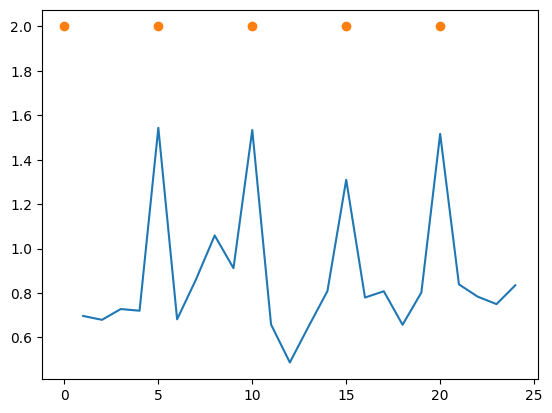

In [221]:
Keys = list(resTotalFrame.keys())

# Compute norms for consecutive keys
norms = [
    np.linalg.norm(
        resTotalFrame[Keys[i]]["precision"] - resTotalFrame[Keys[i + 1]]["precision"],
        "fro"
    )
    for i in range(len(Keys) - 1)
]
x  = np.linspace(1,24,24)
x1 = np.linspace(0,20,5)
print(x)
print(x1)
plt.plot(x,norms)
plt.plot(x1, np.repeat(2, 5), marker="o", linestyle="") 

In [ ]:
winLen = 200
log_returns.iloc[0:winLen,:]
res = fit_multivariate_t(random_samples,ptol=1e-8)
Sigma = res["Sigma"]
Sigma



array([[ 7.48976031e-02,  7.12242087e-03,  1.54996954e-02,
        -5.54533308e-03,  3.72720365e-03,  4.11889659e-03,
        -3.07549886e-03, -2.07887449e-02,  1.57762003e-02,
        -9.88676103e-03],
       [ 7.12242087e-03,  7.49027024e-02,  5.80241682e-03,
         2.77795097e-04, -1.99859555e-03,  3.00045667e-03,
         2.16867743e-02,  8.14997833e-03, -9.90935855e-05,
         4.59025566e-03],
       [ 1.54996954e-02,  5.80241682e-03,  6.43340318e-02,
         7.16085116e-04,  6.53145138e-04, -4.50441659e-04,
        -7.35110216e-03,  3.22695553e-04, -6.61656941e-04,
         2.72831551e-03],
       [-5.54533308e-03,  2.77795097e-04,  7.16085116e-04,
         7.95068882e-02,  1.12186840e-02,  9.72928439e-03,
        -2.13903079e-02,  2.07759920e-02,  1.12473266e-02,
         1.46648023e-02],
       [ 3.72720365e-03, -1.99859555e-03,  6.53145138e-04,
         1.12186840e-02,  9.02710386e-02,  5.79714188e-03,
        -1.09958621e-02,  1.21058063e-02,  3.25342807e-03,
         1.